# <center> `Asian Religions Data` </center>

In [1]:
# Pakiety
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from collections import Counter 
import matplotlib.pyplot as plt
import re
import math
plt.rcParams["figure.figsize"] = (20,10)
# Ustawienie ziarna, pozwala zachować reprodukowalność wyników
np.random.seed(123)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Wczytanie danych
data = pd.read_csv("./AsianReligionsData/AllBooks_baseline_DTM_Labelled.csv")
data.rename({"Unnamed: 0" : "Title"}, axis='columns', inplace=True)
data.set_index("Title", inplace=True)

# Etap 1.

## Uzupełnienie analizy eksploracyjnej

### Rodziały

In [3]:
print(f"Przeprowadzona analiza eksploracyjna dowiodła, że wszystkie księgi mają w sumie {data.shape[0]} rozdziałów.")

Przeprowadzona analiza eksploracyjna dowiodła, że wszystkie księgi mają w sumie 590 rozdziałów.


Ponadto, okazuje się, istnieją rozdziały, zawierające znikome ilości słów.

In [4]:
data.sum(axis=1).sort_values(ascending=False)

Title
Buddhism_Ch37                 1194
BookOfEccleasiasticus_Ch47     557
Buddhism_Ch42                  522
BookOfEccleasiasticus_Ch23     414
BookOfEccleasiasticus_Ch24     400
                              ... 
Upanishad_Ch128                  8
Upanishad_Ch103                  7
Upanishad_Ch125                  7
Upanishad_Ch143                  6
Buddhism_Ch14                    0
Length: 590, dtype: int64

In [5]:
print(f"{round((data.sum(axis=1) < 50).sum() * 100/ data.shape[0], 2)}% rozdziałów zawiera poniżej 50 słów.")

38.47% rozdziałów zawiera poniżej 50 słów.


Biorąc pod uwagę powyższe spostrzeżenia, nasuwa się wniosek, że klasteryzacja, w której skupienie odpowiada danemu rozdziałowi, nie ma sensu.

## Weryfikacja korelacji

Obserwacją, z poprzedniego etapu, którą postanowiliśmy poddać weryfikacji jest duża liczba silnie skorelowanych słów. W trakcie prezentacji projektu, pojawiła się hipoteza, że silna zależność spowodowana jest tym, że wyrazy parami zależne, są unikalne. Okazuje się, że w analizowanym zbiorze faktycznie występuje duża liczba słów występujących rzadko w obrębie wszystkich rozdziałów.

### Wyrazy unikalne

In [6]:
print(f" W zbiorze {round((data.sum(axis=0) == 1).sum() / data.shape[1] * 100, 2)}% wyrazów jest unikalnych")

 W zbiorze 42.55% wyrazów jest unikalnych


### Odsetek zer w zbiorze danych

In [7]:
data.head()

,foolishness,hath,wholesome,takest,feelings,anger,vaivaswata,matrix,kindled,convict,...,erred,thinkest,modern,reigned,sparingly,visual,thoughts,illumines,attire,explains
Title,,,,,,,,,,,,,,,,,,,,,
Buddhism_Ch1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Buddhism_Ch2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Buddhism_Ch3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Buddhism_Ch4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Buddhism_Ch5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
print(f"{ 100 - round(data.astype('bool').sum().sum() / (data.shape[0] * data.shape[1]) * 100, 2)}% danych w zbiorze to zera")

99.14% danych w zbiorze to zera


Zatem, faktycznie okazuje się, że hipoteza była zasadna

### Zgrupowanie rozdziałów do ksiąg

In [9]:
# Nazwa księgi jest oddzielona od nazwy rozdziałów przez "_", 
# aby uzyskać nazwę księgi należy podzielić index względem tego znaku i zachować pierwszy człon.

In [10]:
data['book'] = data.index.to_series().str.split("_", expand = True)

In [11]:
data['book'].unique().tolist()

['Buddhism',
 'TaoTeChing',
 'Upanishad',
 'YogaSutra',
 'BookOfProverb',
 'BookOfEcclesiastes',
 'BookOfEccleasiasticus',
 'BookOfWisdom']

Jeżeli w klasteryzacji skupienie miałoby odpowiadać księdze danej religii, wówczas należało by zaagregować  *'BookOfProverb', 'BookOfEcclesiastes', 'BookOfEccleasiasticus' i 'BookOfWisdom'*, ponieważ wszystkie wywodzą się z religii chrześcijańskich. 

In [12]:
data.book.replace({
    "BookOfProverb": "Bible",
    "BookOfEccleasiasticus": "Bible",
    "BookOfEcclesiastes": "Bible",
    "BookOfWisdom": "Bible"}, inplace=True)

In [13]:
data['book'].unique().tolist()

['Buddhism', 'TaoTeChing', 'Upanishad', 'YogaSutra', 'Bible']

## Wordnet

In [14]:
! pip3 install nltk

In [15]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/elzbieta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
from nltk.corpus import wordnet

Chcąc zbadać czy istnieje problem występowania w zbiorze wielu synonimów, chciałam przetestować rozwiązanie polegające na obliczeniu podobieństwa sensu wyrazów i zgrupowaniu tych najbardziej podobnych.

In [17]:
def search(words_list, index):
    w = wordnet.synsets(words[index])
    
    # jeśli nie znaleziono słowa
    if len(w) == 0:
        return(None)
    elif w[0].name().split(".")[0] != words[index]:
        return(None)
    
    return(w[0])

In [18]:
def similarity_matrix(words_list):
    n = len(words_list)
    M = np.zeros((n, n))

    for i in range (n):
        
        w1 = search(words_list, i)
        if w1 is None: 
            M[i, :] = -1
            continue
            
        for j in range (i+1, n):
            w2 = search(words_list, j)
            if w2 is None: 
                M[:, j] = -1
                continue
                
            if M[i, j] == 0:
                M[i, j] = w1.path_similarity(w2)
    return M

In [19]:
words = data.columns
sim_matr = similarity_matrix(words)

In [21]:
sim_val = sim_matr[~np.isnan(sim_matr)]
sim_val = sim_matr[sim_matr > 0]

In [41]:
n = len(words)
print(f"Zaledwie {round(len(sim_val) * 100/(n*(n-1)/2), 2)}% danych w nowopowstałej macierzy jest informatywnych.")

Zaledwie 8.86% danych w nowopowstałej macierzy jest informatywnych.


Podejście to, ze względu na mnogość obliczeń, jest czasochłonne i dla tej postaci danych zdecydowanie nie jest efektywne.

In [42]:
np.unique(sim_val)

array([0.03225806, 0.03333333, 0.03448276, 0.03571429, 0.03703704,
       0.03846154, 0.04      , 0.04166667, 0.04347826, 0.04545455,
       0.04761905, 0.05      , 0.05263158, 0.05555556, 0.05882353,
       0.0625    , 0.06666667, 0.07142857, 0.07692308, 0.08333333,
       0.09090909, 0.1       , 0.11111111, 0.125     , 0.14285714,
       0.16666667, 0.2       , 0.25      , 0.33333333, 0.5       ])

W uzyskanej, w rezultacie, macierzy nie widać problemu występowania wyrazów bliskoznacznych. Tym nie mniej, wiedza ta nie jest wiążąca i nie może być wykorzystana, ponieważ jest to wniosek wyciągnięty na podstawie nielicznej podpróbki danych.

# Etap 2.

## Czyszczenie danych

In [4]:
data2 = data

In [9]:
words = data2.columns
words

Index(['foolishness', 'hath', 'wholesome', 'takest', 'feelings', 'anger',
       'vaivaswata', 'matrix', 'kindled', 'convict',
       ...
       'erred', 'thinkest', 'modern', 'reigned', 'sparingly', 'visual',
       'thoughts', 'illumines', 'attire', 'explains'],
      dtype='object', length=8266)

In [10]:
lengths = [[len(i), i] for i in words]
lengths = sorted(lengths, reverse=True)

In [11]:
[i[1] if wordnet.morphy(i[1]) is None else None for i in lengths]

['consciousnessconsciousness',
 'clingingclingingsustenance',
 'neitherpleasantnorpainful',
 'neitherpainfulnorpleasant',
 'fabricationsfabrications',
 'neitherpleasurenorpain',
 'lamentationlamentation',
 'intellectconsciousness',
 'argumentativethought',
 'tongueconsciousness',
 'stressfulsariputta',
 'fabricationsmental',
 'clingingsustenance',
 'clingingaggregates',
 'soulconsciousness',
 'selfconsciousness',
 'selfcomprehension',
 'propertysariputta',
 'noseconsciousness',
 'fabricationverbal',
 None,
 'consciousnesshood',
 'clingingaggregate',
 'bodyconsciousness',
 None,
 'threedimensional',
 'senseimpressions',
 'selfreproductive',
 'intellectcontact',
 None,
 'eyeconsciousness',
 'earconsciousness',
 'distressdistress',
 'becomingbecoming',
 'allconsciousness',
 'allcomprehending',
 None,
 None,
 'stumblingblocks',
 None,
 'senseperception',
 'selfrecognition',
 'selfrealization',
 'selfcomplacency',
 'lightmindedness',
 'lealheartedness',
 None,
 'intellectsphere',
 'fourdime

Należałoby oczyścić te kolumny. Proponowane kroki:
- wyrzucić TRUE i FALSE
- oczyścić kolumny z dwukrotnymi słowami (to pierwsze szczególnie)
- oddzielić "consciousness" od końców słów
- rozdzielić słowa typu "neither...nor..."
- resztę rozdzielić na słowa, szukając miejsca, gdzie da się rozdzielić słowo na dwa takie, które są w zbiorze kolumn (tylko to drugie spełnia np. "sariputta"); jeśli nie ma takiego podziału lub istnieją co najmniej dwa, zostawić (drugą kategorią zajmiemy się chyba ręcznie)
- DALSZĄ resztę skleić Wordnetem

In [12]:
def forms(word):
    formlist = []
    for x in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        mo = wordnet.morphy(word, x)
        if not mo is None:
            formlist.append(mo)
    if formlist==[]:
        return None
    else:
        return sorted(formlist, key=len)

In [13]:
data2 = data2.drop(columns=['TRUE', 'FALSE'])

In [14]:
for W in words:
    if len(W)%2==0:
        W2 = W[0:len(W)//2]
        if W==W2*2 and W2 in data2.columns:
            data2[W2]=data2[W2]+2*data2[W]
            data2 = data2.drop(columns=[W])

In [15]:
words = data2.columns
for W in words:
    if len(W)>13 and forms(W) is None:
        W2 = W[:-13]
        if W2 in data2.columns and W[-13:]=='consciousness':
            data2[W2]=data2[W2]+data2[W]
            data2['consciousness']=data2['consciousness']+data2[W]
            data2=data2.drop(columns=[W])

In [16]:
import re

In [17]:
data2['nor'] = 0

In [18]:
words = data2.columns
for W in words:
    if not re.search('neither.*nor.*', W) is None:
        m = re.search('neither(.*)nor(.*)', W)
        W1 = m.group(1)
        W2 = m.group(2)
        if not W1 in data2.columns:
            data[W1] = 0
        if not W2 in data2.columns:
            data[W2] = 0
        data2['neither']=data2['neither']+data2[W]
        data2['nor']=data2['nor']+data2[W]
        data2[W1]=data2[W1]+data2[W]
        data2[W2]=data2[W2]+data2[W]
        data2=data2.drop(columns=[W])

In [19]:
len(data2.columns)

8238

In [20]:
words = data2.columns
lengths = [i for i in words if wordnet.morphy(i) is None]
lengths.sort(key=len, reverse=True)
lengths

['clingingclingingsustenance',
 'argumentativethought',
 'clingingsustenance',
 'clingingaggregates',
 'stressfulsariputta',
 'fabricationsmental',
 'clingingaggregate',
 'selfcomprehension',
 'fabricationverbal',
 'consciousnesshood',
 'propertysariputta',
 'senseimpressions',
 'intellectcontact',
 'threedimensional',
 'allcomprehending',
 'selfreproductive',
 'lightmindedness',
 'selfrealization',
 'senseperception',
 'lealheartedness',
 'fourdimensional',
 'fabricationhood',
 'selfrecognition',
 'selfcomplacency',
 'intellectsphere',
 'stumblingblocks',
 'elegantlooking',
 'onepointedness',
 'oilofthejoints',
 'lifeincreasing',
 'selfexpression',
 'firesacrifices',
 'discernibility',
 'perceptionhood',
 'selfindulgence',
 'godenlightened',
 'grapegatherers',
 'stumblingblock',
 'sentencemakers',
 'themselvesibid',
 'selfabsorption',
 'samsaravriksha',
 'selfaffliction',
 'wellpenetrated',
 'forgetfullness',
 'terrorstricken',
 'incommunicable',
 'thoughtreading',
 'tortoiseformed',


Co nam zostało?
- resztę rozdzielić na słowa, szukając miejsca, gdzie da się rozdzielić słowo na dwa takie, które są w zbiorze kolumn; jeśli nie ma takiego podziału lub istnieją co najmniej dwa, zostawić (drugą kategorią zajmiemy się chyba ręcznie)
- DALSZĄ resztę skleić Wordnetem

Odnośnie drugiego punktu - są w zbiorze staroangielskie formy czasowników kończące się na "eth", których Wordnet nie rozpoznaje. Te oczywiście też wyczyścimy

In [21]:
words = list(data2.columns)
words.remove("sittest")
# doświadczalnie uznałem, że "sittest" należy zostawić
# jedyne słowo, którego podział nie zachowałby zupełnie sensu
# ("everybody", "selfconscious" jeszcze w porządku, ale z "sittest" wychodzi "test")
for W in words:
    if forms(W) is None and len(W)>=6:
        L = len(W)
        cand = []
        for p in range(3, L-2):
            if W[:p] in data2.columns and W[p:] in data2.columns:
                cand.append(p)
        if len(cand)==1:
            p = cand[0]
            data2[W[:p]]=data2[W[:p]]+data2[W]
            data2[W[p:]]=data2[W[p:]]+data2[W]
            data2=data2.drop(columns=[W])

In [22]:
len(data2.columns)

8087

In [23]:
words = data2.columns
for W in words:
    if forms(W) is None:
        L = len(W)
        cand = []
        for p in range(3, L-2):
            if W[:p] in data2.columns and W[p:] in data2.columns:
                cand.append(p)
        if len(cand)>1:
            print(W)

Słowa o co najmniej dwóch teoretycznie możliwych podziałach nie wystąpiły.

In [24]:
words = list(data2.columns)
words.remove("book")
for W in words:
    F=forms(W)
    # funkcję forms napisałem tak, by na początku listy zawsze dawała najkrótsze słowo
    if not F is None:
        W1=F[0]
        if W1=="book":
            # book to inna kolumna
            W1="books"
        if not W1==W:
            if not W1 in data2.columns:
                data2[W1]=data2[W]
            else:
                data2[W1]=data2[W1]+data2[W]
            data2 = data2.drop(columns=[W])

In [25]:
data3=data2
len(data3.columns)
# checkpoint, poprzednia komórka długo się robi

5905

In [26]:
words = data3.columns
lengths = [i for i in words if wordnet.morphy(i) is None]
lengths.sort(key=len, reverse=True)
lengths

['clingingclingingsustenance',
 'consciousnesshood',
 'threedimensional',
 'selfreproductive',
 'lightmindedness',
 'lealheartedness',
 'fourdimensional',
 'fabricationhood',
 'selfcomplacency',
 'intellectsphere',
 'stumblingblocks',
 'onepointedness',
 'oilofthejoints',
 'discernibility',
 'perceptionhood',
 'grapegatherers',
 'stumblingblock',
 'themselvesibid',
 'samsaravriksha',
 'terrorstricken',
 'incommunicable',
 'tortoiseformed',
 'nursingmother',
 'betweenthetwo',
 'allencircling',
 'supersensuous',
 'communicateth',
 'transgresseth',
 'sankaracharya',
 'understandeth',
 'purposiveness',
 'nonperception',
 'deathlessness',
 'illcultivated',
 'selfassertion',
 'thoughtreader',
 'remainderless',
 'sophistically',
 'extinguisheth',
 'moistureladen',
 'beautifulness',
 'sacrificially',
 'respondedthe',
 'enlighteneth',
 'pratyagatman',
 'churlishness',
 'tonguesphere',
 'overwhelmeth',
 'brahmacharya',
 'endeavoureth',
 'unfabricated',
 'dishonoureth',
 'luminiferous',
 'unsearc

In [27]:
for W in words:
    if len(W)>3 and forms(W) is None:
        if W[-3:] in ["eth", "est"] and not (forms(W[:-3]) is None and forms(W[:-2]) is None):
            if not forms(W[:-3]) is None:
                W2=W[:-3]
            elif not forms(W[:-2]) is None:
                W2=W[:-2]
            if W2 in data3.columns:
                data3[W2]=data3[W2]+data3[W]
            else:
                data3[W2]=data3[W]
            data3=data3.drop(columns=[W])
len(data3.columns)

5553

In [28]:
words=data3.columns
for W in words:
    if len(W)>2 and forms(W) is None:
        if W[-2:]=="st" and not forms(W[:-2]) is None:
            W2=W[:-2]
            if W2 in data3.columns:
                data3[W2]=data3[W2]+data3[W]
            else:
                data3[W2]=data3[W]
            data3=data3.drop(columns=[W])
len(data3.columns)

5551

In [29]:
words=data3.columns
for W in words:
    if len(W)>4 and forms(W) is None:
        if W[-4:]=="ieth" and W[:-4]+"y" in data3.columns:
            W2=W[:-4]+"y"
            if W2 in data3.columns:
                data3[W2]=data3[W2]+data3[W]
                data3=data3.drop(columns=[W])
len(data3.columns)

5539

In [30]:
words = data3.columns
lengths = [i for i in words if wordnet.morphy(i) is None]
lengths.sort(key=len, reverse=True)
lengths

['clingingclingingsustenance',
 'consciousnesshood',
 'threedimensional',
 'selfreproductive',
 'lightmindedness',
 'lealheartedness',
 'fourdimensional',
 'fabricationhood',
 'selfcomplacency',
 'intellectsphere',
 'stumblingblocks',
 'onepointedness',
 'oilofthejoints',
 'discernibility',
 'perceptionhood',
 'grapegatherers',
 'stumblingblock',
 'themselvesibid',
 'samsaravriksha',
 'terrorstricken',
 'incommunicable',
 'tortoiseformed',
 'nursingmother',
 'betweenthetwo',
 'allencircling',
 'supersensuous',
 'sankaracharya',
 'purposiveness',
 'nonperception',
 'deathlessness',
 'illcultivated',
 'selfassertion',
 'thoughtreader',
 'remainderless',
 'sophistically',
 'moistureladen',
 'beautifulness',
 'sacrificially',
 'respondedthe',
 'pratyagatman',
 'churlishness',
 'tonguesphere',
 'brahmacharya',
 'unfabricated',
 'luminiferous',
 'unsearchable',
 'harmlessness',
 'selfreliance',
 'mahakotthita',
 'wellpondered',
 'nonconfusion',
 'fivefactored',
 'symbolofrank',
 'concertatio

Teraz przydałoby się wyrzucić kolumny typu "submitteth" i "preferreth"

In [31]:
words = data3.columns
for W in words:
    if len(W)>5 and forms(W) is None:
        if W[-3:] in ["eth", "est"] and not forms(W[:-4]) is None and W[-5]==W[-4]:
            W2=W[:-4]
            if W2 in data3.columns:
                data3[W2]=data3[W2]+data3[W]
            else:
                data3[W2]=data3[W]
            data3=data3.drop(columns=[W])
len(data3.columns)

5520

W niektórych słowach pojawia się też "the", którego Wordnet nie widzi: oilofthejoints, betweenthetwo, respondedthe. Załatwimy to już ręcznie.

In [32]:
data3.oil = data3.oil + data3.oilofthejoints
data3.joint = data3.joint + data3.oilofthejoints
data3.between = data3.betweenthetwo
data3.two = data3.two + data3.betweenthetwo
data3.respond = data3.respond + data3.respondedthe
data3.the = data3.the + data3.oilofthejoints + data3.betweenthetwo + data3.respondedthe
data3 = data3.drop(columns=["oilofthejoints", "betweenthetwo", "respondedthe"])

In [33]:
data3.cling = data3.cling + 2*data3.clingingclingingsustenance
data3.sustenance = data3.sustenance + data3.clingingclingingsustenance
data3.deceitful = data3.deceitful + data3.deceitfnl
data3 = data3.drop(columns=["clingingclingingsustenance", "deceitfnl"])

Jeszcze jedna rzecz - użyję funkcji zdefiniowanej w poprzednim kamieniu milowym.

In [34]:
def groups(words):
    groupsL = []
    i = 0
    j = 0
    mainword = []
    while j < len(words):
        if not re.findall('^' + words[i], words[j]) == []:
            mainword.append(words[j])
            j = j + 1
        else:
            groupsL.append(mainword)
            mainword = []
            i = j
    return groupsL

In [35]:
words = data3.columns
words.sort_values()
G = groups(sorted(words))
[i for i in G if len(i)>1]

[['abase', 'abasement'],
 ['absolute', 'absolutely'],
 ['abundant', 'abundantly'],
 ['aby', 'abysmal'],
 ['accept', 'acceptable', 'acceptance'],
 ['accident', 'accidental'],
 ['accomplish', 'accomplishment'],
 ['accord', 'accordance'],
 ['accuse', 'accuser'],
 ['achieve', 'achievement'],
 ['acquaint', 'acquaintance'],
 ['act',
  'action',
  'activate',
  'active',
  'activity',
  'actor',
  'actual',
  'actually',
  'actuate'],
 ['adapt', 'adaptation'],
 ['add', 'addition', 'address'],
 ['adhere', 'adherent'],
 ['admit', 'admittance'],
 ['adult', 'adulteress', 'adulterous', 'adultery'],
 ['advance', 'advancement'],
 ['advantage', 'advantageous'],
 ['affair', 'affairs'],
 ['affect', 'affection'],
 ['affirm', 'affirmation'],
 ['afflict', 'affliction'],
 ['afterward', 'afterwards'],
 ['age', 'agelong', 'agency', 'agent'],
 ['agree', 'agreeable', 'agreement'],
 ['al',
  'alchemy',
  'alert',
  'alertness',
  'algebra',
  'alien',
  'alienation',
  'alight',
  'alike',
  'alive',
  'alkalin

Wordnet nie rozpoznał wielu końcówek, więc zbudujemy funkcję

In [36]:
data4=data3
words = list(data4.columns)
def merge_cols(suffix):
    global data4
    S = len(suffix)
    for W in words:
        if W[-S:]==suffix:
            W2 = W[:-S]
            W3 = W2+"e"
            if W2 in data4.columns and not W2 in ["book", "form"]:
                data4[W2]=data4[W2]+data4[W]
                data4=data4.drop(columns=[W])
            elif W3 in data4.columns:
                data4[W3]=data4[W3]+data4[W]
                data4=data4.drop(columns=[W])

In [37]:
L = ["hood", "ation", "ate", "ment", "al", "ion", "st", "s", "ed", "ative",
     "ic", "ance", "ant", "ness", "ful", "er", "ry", "ous", "ive",
    "able", "ity", "ship", "th", "ism"]
for L2 in L:
    merge_cols(L2)
len(data4.columns)

4806

Wystarczy. W tym momencie mamy 4806, czyli o prawie połowę mniej kolumn!

In [38]:
data=data4

# Etap 3. 
Embeddingi 
===
Zastosuję pakiet flair.

In [176]:
data_marcel = data 

In [70]:
from flair.embeddings import WordEmbeddings
from flair.data import Sentence

# wykonam słownik zawierający embeddingi dla każdego słowa występującego w wyczyszczonej ramce danych 
def embed_crate(df,embedding):
    
    res = dict()
    embedding 
    for i in df.columns:
       
        sentence = Sentence(i)
        embedding.embed(sentence)
        res[i]=sentence[0].embedding
    return res    
        

In [71]:
embed_dict=embed_crate(data_marcel,WordEmbeddings('glove'))

Otrzymaliśmy odpowiadające słowom wektory co może być bardzo przydatne. Niektórym słowom odpowiadają wektry samych zer.

In [63]:
# Zliczanie wektrorów 0 
def counting_0(embed_dict):
    counter = 0 
    zero_list = []
    for k, v in embed_dict.items():
        if 0 == sum(v): 
            counter+=1
            zero_list.append(k)
    return counter,zero_list        
            
   

In [67]:
counter,zero_list = counting_0(embed_dict)
print(counter)
# Pamiętajmy, że ramka ma tylko nieco ponadn 4000 kolumn więc słów z samymi zerami jest dość sporo.

275


In [69]:
# Sprawdżmy jakie to słowa 
zero_list

# Słowa te to najczęściej nie rozłączone zlepki np nursingmother. Nie będę ich usuwał na tym etapie ale należy 
# mieć w pamięci ich istnienie 


['vaivaswata',
 'nursingmother',
 'lightmindedness',
 'maghavan',
 'axletree',
 'roguery',
 'dungcarts',
 'filthiness',
 'antetype',
 'schismatical',
 'equanimous',
 'pratyagatman',
 'sansara',
 'savatthi',
 'arrogancy',
 'unwearying',
 'jivas',
 'tonguesphere',
 'niggardliness',
 'bethhoron',
 'unthankful',
 'avyaktam',
 'undecaying',
 'unholiness',
 'allencircling',
 'sinlessness',
 'beantiful',
 'offendicula',
 'nosesphere',
 'unpervaded',
 'countervail',
 'threeand',
 'coarising',
 'intermeddle',
 'nonaction',
 'redlotus',
 'auddalaki',
 'unloose',
 'nonbecoming',
 'unbecome',
 'feelingness',
 'shouldst',
 'unsalty',
 'dhammadinna',
 'unfabricated',
 'rabsaces',
 'earsphere',
 'agelong',
 'bodysphere',
 'thig',
 'talebearer',
 'attemper',
 'eyesalve',
 'reproachfully',
 'twosided',
 'supersensuous',
 'unknowledgeable',
 'eyesphere',
 'josedec',
 'viswajit',
 'onepointed',
 'discernibility',
 'unfoldment',
 'phison',
 'abiron',
 'opprobrious',
 'josedech',
 'guerdon',
 'fornicator',

Uzyskaliśmy teraz liczbową reprezentacje słów wciąż nie mamy jednak jak użyć na nich klasteryzacij.

In [177]:
# Sprawdzę jeszcze jedną metodę embeddingu 
# Użycie embeddingu Flair Embeddings jest nie możliwe (albo raczej sensowe) bez właściwego tekstu

embed_dict2 = embed_crate(data_marcel,WordEmbeddings('crawl'))


2020-05-25 13:03:37,842 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.3/en-fasttext-crawl-300d-1M.vectors.npy not found in cache, downloading to /tmp/tmpjx3yppvi


100%|██████████| 1200000128/1200000128 [19:49<00:00, 1008746.85B/s]

2020-05-25 13:23:28,143 copying /tmp/tmpjx3yppvi to cache at /home/jan/.flair/embeddings/en-fasttext-crawl-300d-1M.vectors.npy


2020-05-25 13:23:28,990 removing temp file /tmp/tmpjx3yppvi
2020-05-25 13:23:29,526 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.3/en-fasttext-crawl-300d-1M not found in cache, downloading to /tmp/tmpmmnno7pw


100%|██████████| 39323680/39323680 [00:48<00:00, 810463.51B/s] 

2020-05-25 13:24:18,458 copying /tmp/tmpmmnno7pw to cache at /home/jan/.flair/embeddings/en-fasttext-crawl-300d-1M
2020-05-25 13:24:18,498 removing temp file /tmp/tmpmmnno7pw


Przed zastoswaniem embeddingu dla całego zbioru wybiorę małą próbke i sprawdzę czy działanie przyniosło jakieś efekty w tym celu skorzystam z funkcji przygotowanej w poprzednim etapie.

In [118]:
# W zbiorze mamy księgi podzielone na rozdziały sprawdzę różnicę w częstości słow dla poszczególnych ksiąg 
data_books = data_marcel.copy().reset_index()
# Generowanie tytułów ksiąg
names = []
for i in range (len(data_books)):
    
    names.append(re.findall('([^_]+)',data_books.iloc[i,0])[0])
names = np.unique(names)


# index for selected book 
def index_selected_book(book):
    index = [False] * 590
    for i in range(len(data_books)):
        
        if book == re.findall('([^_]+)',data_books.iloc[i,0])[0]:
            index[i] = True 
    index_number = [ ]
    j = 0 
    for i in index:
        if i:
            index_number.append(j)
        j+=1 
    return index_number
# 
def most_frequent_words(data,n=10):
    words = data.columns
    words = np.delete(words,0)
    words_counter = np.array([0]*4806)
    for i in range(len(data.iloc[:,1])):
        row = np.array(data.iloc[i,:])

        row = np.delete(row,0)
        words_counter= words_counter+row 
    out = dict(zip(words,words_counter))
    out = Counter(out)
    return dict(out.most_common(n))
# Generowanie ramki z informacjami
def information_most_frequent(data,names):
    
    result = []
    
    for i in names:
        w = most_frequent_words(data.iloc[index_selected_book(i),:],100)
        result.append([i,w])
    
    return result

In [119]:
frequent_dict=information_most_frequent(data_books,names)
# Wybiorę 100 najczęściej spotykanych słów w trzech księgach różnych religi i spróbuję dokonać klasteryzacji. 
# Nie będę się na razie przejmować licznością wystąpienia słów.  

Najpierw należy sprawdzić które słowa powatarzają sie w wybranych księgach minowicie 'BookOfWisdom','Buddhism' i 'Upanishad'.

In [144]:
# wspólne słowa 
def get_words_for(frequent_dict,book):
    result = []
    for i in frequent_dict:
        if i[0]==book:
            
            for j in i[1].keys():
                result.append(j)
            return result
    return None    
            
print(f"BookOfWisdom+Buddhism :{set(get_words_for(frequent_dict,'BookOfWisdom')).intersection(set(get_words_for(frequent_dict,'Buddhism')))}")
print(f"BookOfWisdom+Upanishad :{set(get_words_for(frequent_dict,'BookOfWisdom')).intersection(set(get_words_for(frequent_dict,'Upanishad')))}")
print(f"Buddhism+Upanishad :{set(get_words_for(frequent_dict,'Buddhism')).intersection(set(get_words_for(frequent_dict,'Upanishad')))}")

BookOfWisdom+Buddhism :{'one', 'see', 'away', 'pass', 'water', 'go', 'knowledge', 'come', 'end', 'world', 'life', 'thing', 'call', 'know', 'way', 'neither', 'make', 'ear'}
BookOfWisdom+Upanishad :{'also', 'see', 'knowledge', 'l', 'father', 'thee', 'word', 'therefore', 'one', 'like', 'think', 'give', 'may', 'light', 'go', 'come', 'world', 'desire', 'know', 'death', 'great', 'life', 'without', 'eve', 'call', 'seek', 'fire', 'soul', 'god', 'man', 'thing', 'thy', 'thou'}
Buddhism+Upanishad :{'see', 'become', 'knowledge', 'self', 'true', 'one', 'mind', 'go', 'come', 'world', 'form', 'know', 'body', 'regard', 'act', 'conscious', 'say', 'life', 'call', 'be', 'long', 'thus', 'thing', 'lead', 'speech'}


In [147]:
# Słów powtarzających się jest dość dużo 
print(f"BookOfWisdom+Buddhism+Upanishad :{set(set(get_words_for(frequent_dict,'BookOfWisdom')).intersection(set(get_words_for(frequent_dict,'Buddhism')))).intersection(set(get_words_for(frequent_dict,'Upanishad')))}")

BookOfWisdom+Buddhism+Upanishad :{'see', 'go', 'knowledge', 'come', 'world', 'know', 'life', 'thing', 'call', 'one'}


Ale niewiele słów powtarza się we wszystkich księgach.

In [156]:
# Przygotowanie danych do testu 
BofW_set=set(get_words_for(frequent_dict,'BookOfWisdom'))
Budd_set=set(get_words_for(frequent_dict,'Buddhism'))
unpa_set=set(get_words_for(frequent_dict,'Upanishad'))

final_set = BofW_set.union(Budd_set)
final_set = final_set.union(unpa_set)

len(final_set)

234

In [164]:
# data frame 
def sub_dict(final_set,embed_dict):
    res = dict()
    for k,v in embed_dict.items():
        if k in final_set:
            res[k]=v.tolist()
    return res

In [178]:
glove_df = pd.DataFrame(sub_dict(final_set,embed_dict)).T
fast_df = pd.DataFrame(sub_dict(final_set,embed_dict2)).T

In [173]:
# Klasteryzacja z pomocą KMeans i ustalanie liczby klastrów poprzez indeks DB

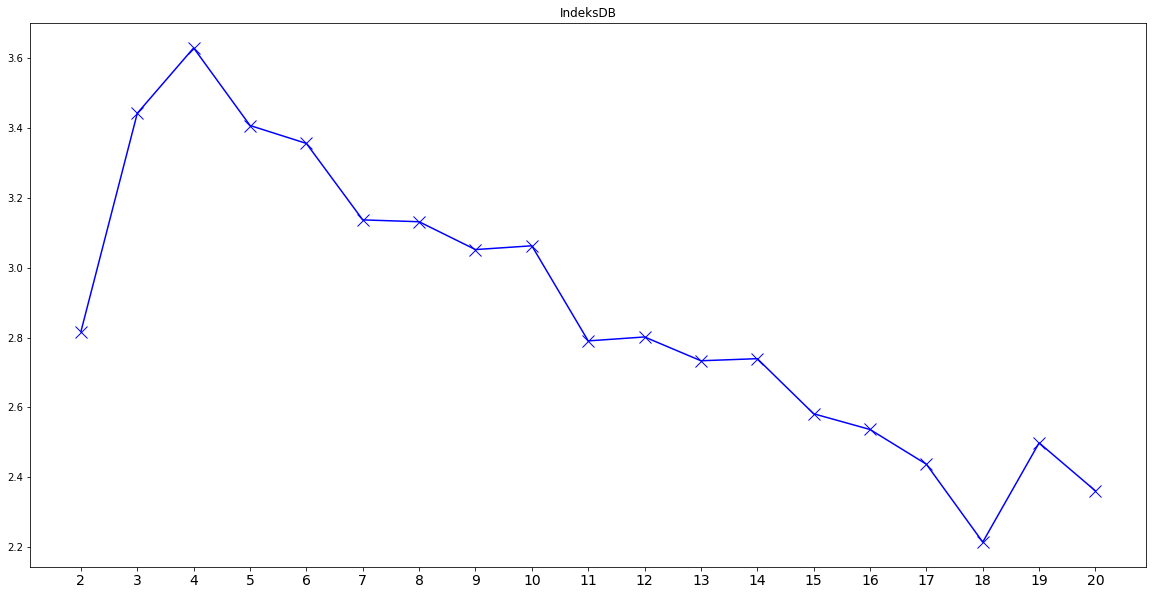

In [181]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

def indeskDB(df,sk,ek):
    scores=[]
    for i in range(sk,ek+1):
        model = KMeans(i)
        lebals = model.fit(df)
        labels = model.labels_
        scores.append(davies_bouldin_score(df, labels))
    # Result 

    plt.plot([i for i in range(sk,ek+1)], scores, 'bx-',markersize=12)
    plt.xticks(fontsize=14)
    plt.title('IndeksDB')
    plt.xticks([i for i in range(sk,ek+1)])
    plt.show()
indeskDB(glove_df,2,20)
# W oczekiwanej liczbie klastrów odpowiadającej księgom indeks jest najwyższy co oznacza niepowodzenie eksperymentu

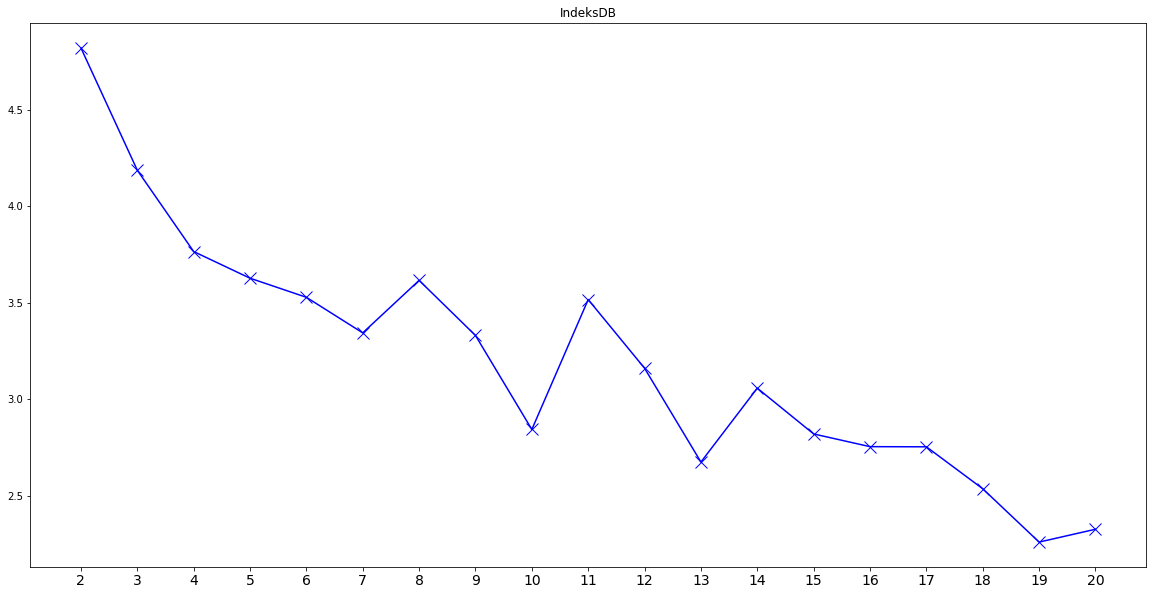

In [183]:
# Dla porównania drugi embedding 
indeskDB(fast_df,2,20)
# wyniki również dalekie od zadowalających. Zignorowanie liczby słow okazało się złym pomysłem